In [1]:
# data loading
import json
import pandas as pd

with open('processed_text_balanced.json','r+') as js_file:
    jsobj = json.load(js_file)

df = pd.DataFrame(jsobj)

In [3]:
# import everything
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [4]:
# split by 'split' column
train_data = df[df['split'] == 'train']
dev_data = df[df['split'] == 'dev']
test_data = df[df['split'] == 'test']

In [5]:
# Convert sentiment text labels into numerical values
y_train, _ = pd.factorize(train_data['sentiment'])
y_dev, _ = pd.factorize(dev_data['sentiment'])
y_test, _ = pd.factorize(test_data['sentiment'])

### 1 without GridSearchCV
#### 1.1 Without ID

In [6]:
#feature extraction

tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(train_data['clean']).toarray()
X_dev_tfidf = tfidf.transform(dev_data['clean']).toarray()
X_test_tfidf = tfidf.transform(test_data['clean']).toarray()


In [23]:
#model training and evaluation
model = LogisticRegression(max_iter=5000)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
grid_search = GridSearchCV(model, param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters (without ID):", grid_search.best_params_)
print("Best cross-validation score (without ID):", grid_search.best_score_)

# determine the best model
best_model_without_id = grid_search.best_estimator_

#test
final_predictions_without_id = best_model_without_id.predict(X_test_tfidf)
final_accuracy_without_id = accuracy_score(y_test, final_predictions_without_id)
print("Final Test Accuracy (without ID):", final_accuracy_without_id)

Best parameters (without ID): {'C': 1}
Best cross-validation score (without ID): 0.6165900517971112
Final Test Accuracy (without ID): 0.4306513409961686


#### 1.2 With ID

In [9]:
# add ID features (diaID and uttID)
X_train_with_id = np.hstack((X_train_tfidf, train_data[['diaID', 'uttID']].values))
X_dev_with_id = np.hstack((X_dev_tfidf, dev_data[['diaID', 'uttID']].values))
X_test_with_id = np.hstack((X_test_tfidf, test_data[['diaID', 'uttID']].values))

In [10]:
# standardization
scaler_with_id = StandardScaler()
X_train_with_id_scaled = scaler_with_id.fit_transform(X_train_with_id)
X_dev_with_id_scaled = scaler_with_id.transform(X_dev_with_id)
X_test_with_id_scaled = scaler_with_id.transform(X_test_with_id)

In [22]:
# model training and evaluation
model = LogisticRegression(max_iter=10000)
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,10000]}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
grid_search_with_id = GridSearchCV(model, param_grid, cv=skf, scoring='accuracy')
grid_search_with_id.fit(X_train_with_id_scaled, y_train)

print("Best parameters (with ID):", grid_search_with_id.best_params_)
print("Best cross-validation score (with ID):", grid_search_with_id.best_score_)

# determine the best model
best_model_with_id = grid_search_with_id.best_estimator_

#test
final_predictions_with_id = best_model_with_id.predict(X_test_with_id_scaled)
final_accuracy_with_id = accuracy_score(y_test, final_predictions_with_id)
print("Final Test Accuracy (with ID):", final_accuracy_with_id)

Best parameters (with ID): {'C': 0.001}
Best cross-validation score (with ID): 0.6094241084899015
Final Test Accuracy (with ID): 0.41800766283524904


### 2 without GridSearchCV 
#### 2.1 without ID

In [21]:
# model initialization
model_without_GridSearchCV = LogisticRegression(max_iter=5000)

# 5-fold CV
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2024)
cv_scores = []

for train_idx, dev_idx in skf.split(X_train_tfidf, y_train):
    X_cv_train, X_cv_dev = X_train_tfidf[train_idx], X_train_tfidf[dev_idx]
    y_cv_train, y_cv_dev = y_train[train_idx], y_train[dev_idx]
    
    model_without_GridSearchCV.fit(X_cv_train, y_cv_train)
    predictions = model_without_GridSearchCV.predict(X_cv_dev)
    cv_score = accuracy_score(y_cv_dev, predictions)
    cv_scores.append(cv_score)

print("CV Accuracy Scores without ID:", cv_scores)
print("Average CV Accuracy without ID:", np.mean(cv_scores))

CV Accuracy Scores without ID: [0.6017000607164542, 0.6290224650880388, 0.6272009714632666, 0.6059502125075895, 0.6190765492102066]
Average CV Accuracy without ID: 0.6165900517971112


#### 2.2 with ID

In [17]:
# add ID features (diaID and uttID)
X_train_with_id = np.hstack((X_train_tfidf, train_data[['diaID', 'uttID']].values))
X_dev_with_id = np.hstack((X_dev_tfidf, dev_data[['diaID', 'uttID']].values))
X_test_with_id = np.hstack((X_test_tfidf, test_data[['diaID', 'uttID']].values))

In [18]:
# standardization
scaler_with_id = StandardScaler()
X_train_with_id_scaled = scaler_with_id.fit_transform(X_train_with_id)
X_dev_with_id_scaled = scaler_with_id.transform(X_dev_with_id)
X_test_with_id_scaled = scaler_with_id.transform(X_test_with_id)

In [19]:
# model initialization
model_without_GridSearchCV = LogisticRegression(max_iter=5000)

# 5-fold CV
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2024)
cv_scores = []

for train_idx, dev_idx in skf.split(X_train_with_id_scaled, y_train):
    X_cv_train, X_cv_dev = X_train_with_id_scaled[train_idx], X_train_with_id_scaled[dev_idx]
    y_cv_train, y_cv_dev = y_train[train_idx], y_train[dev_idx]
    
    model_without_GridSearchCV.fit(X_cv_train, y_cv_train)
    predictions = model_without_GridSearchCV.predict(X_cv_dev)
    cv_score = accuracy_score(y_cv_dev, predictions)
    cv_scores.append(cv_score)

print("CV Accuracy Scores with ID:", cv_scores)
print("Average CV Accuracy with ID:", np.mean(cv_scores))

CV Accuracy Scores with ID: [0.5695203400121432, 0.6180935033394049, 0.6041287188828173, 0.5737704918032787, 0.5838396111786148]
Average CV Accuracy with ID: 0.5898705330432519


## Results
### 1 without GridSearchCV
#### 1.1 Without ID

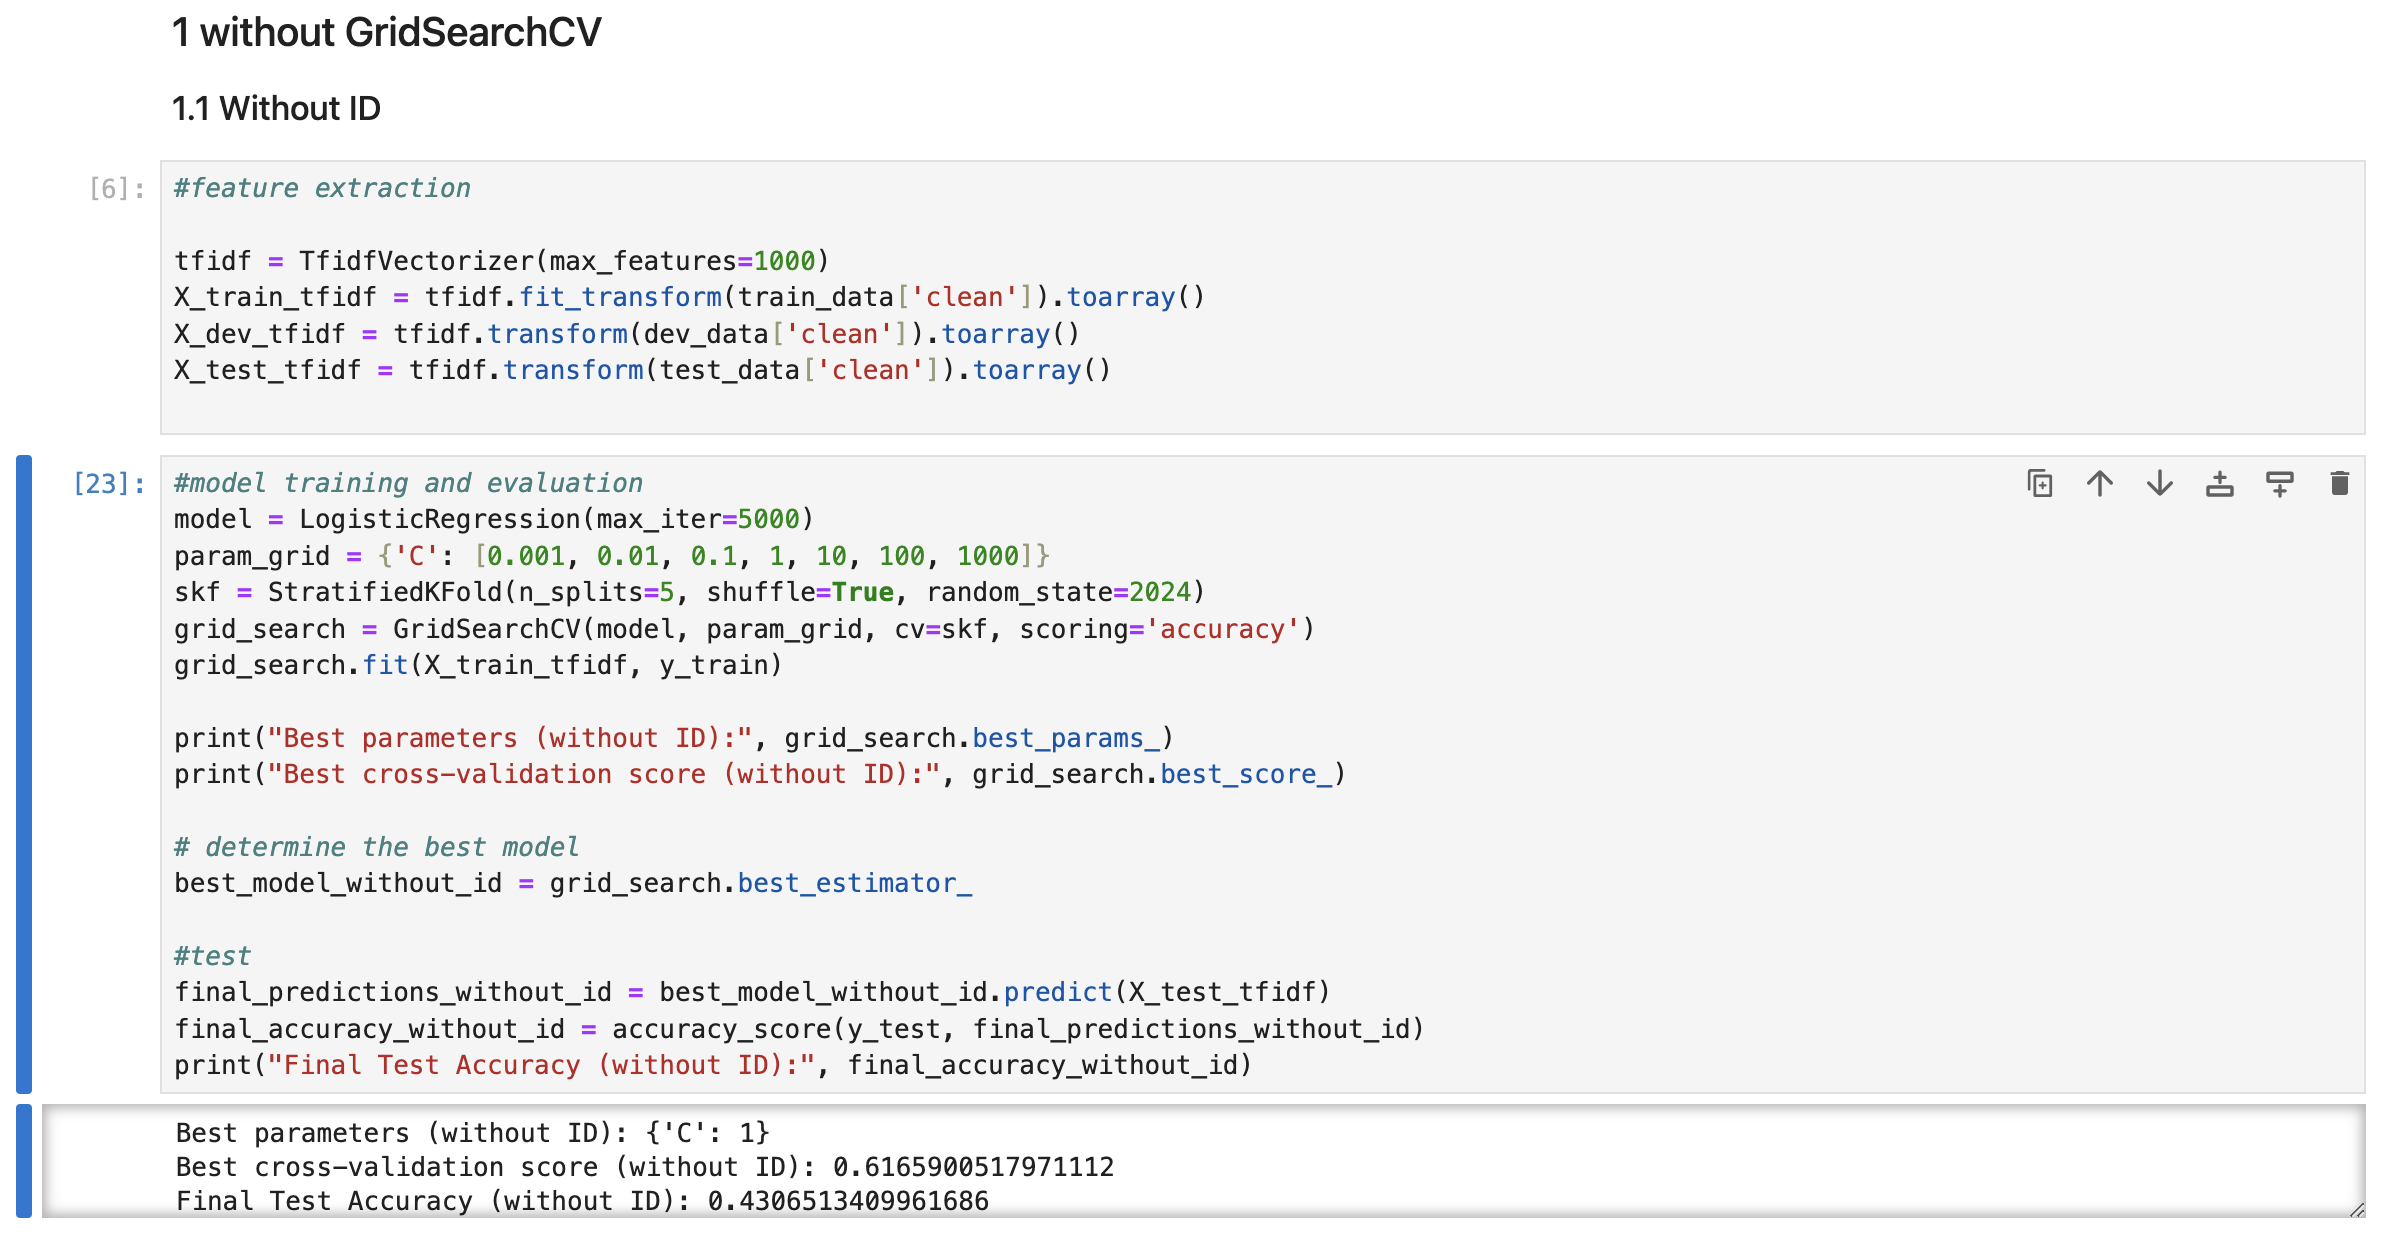

#### 1.2 With ID

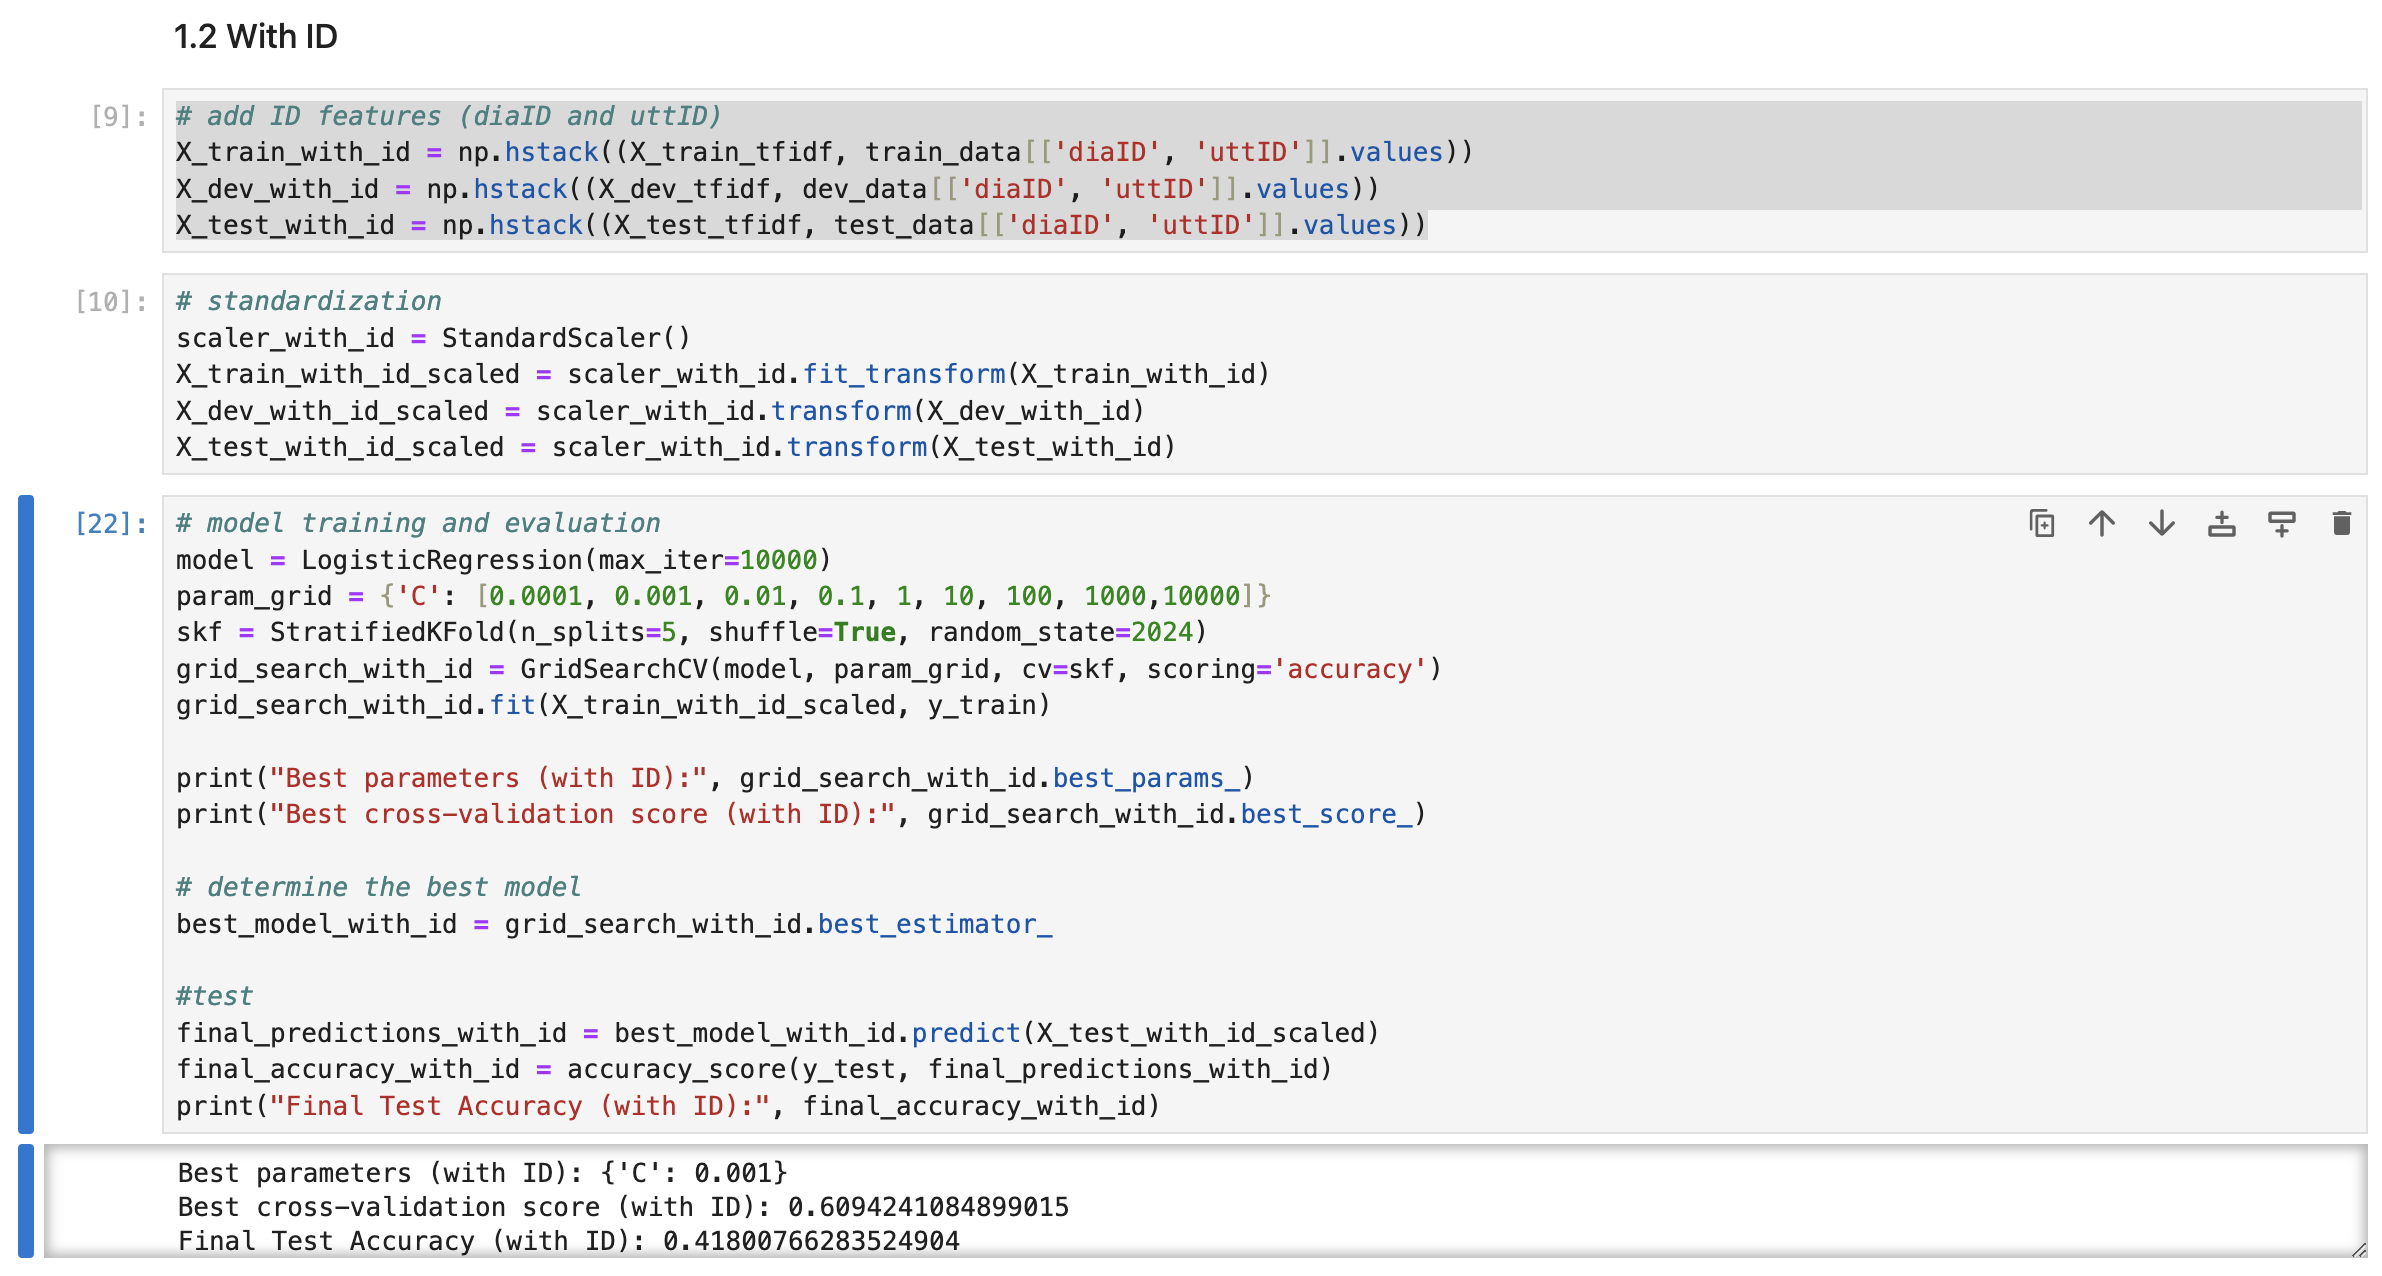

### 2 without GridSearchCV
#### 2.1 Without ID

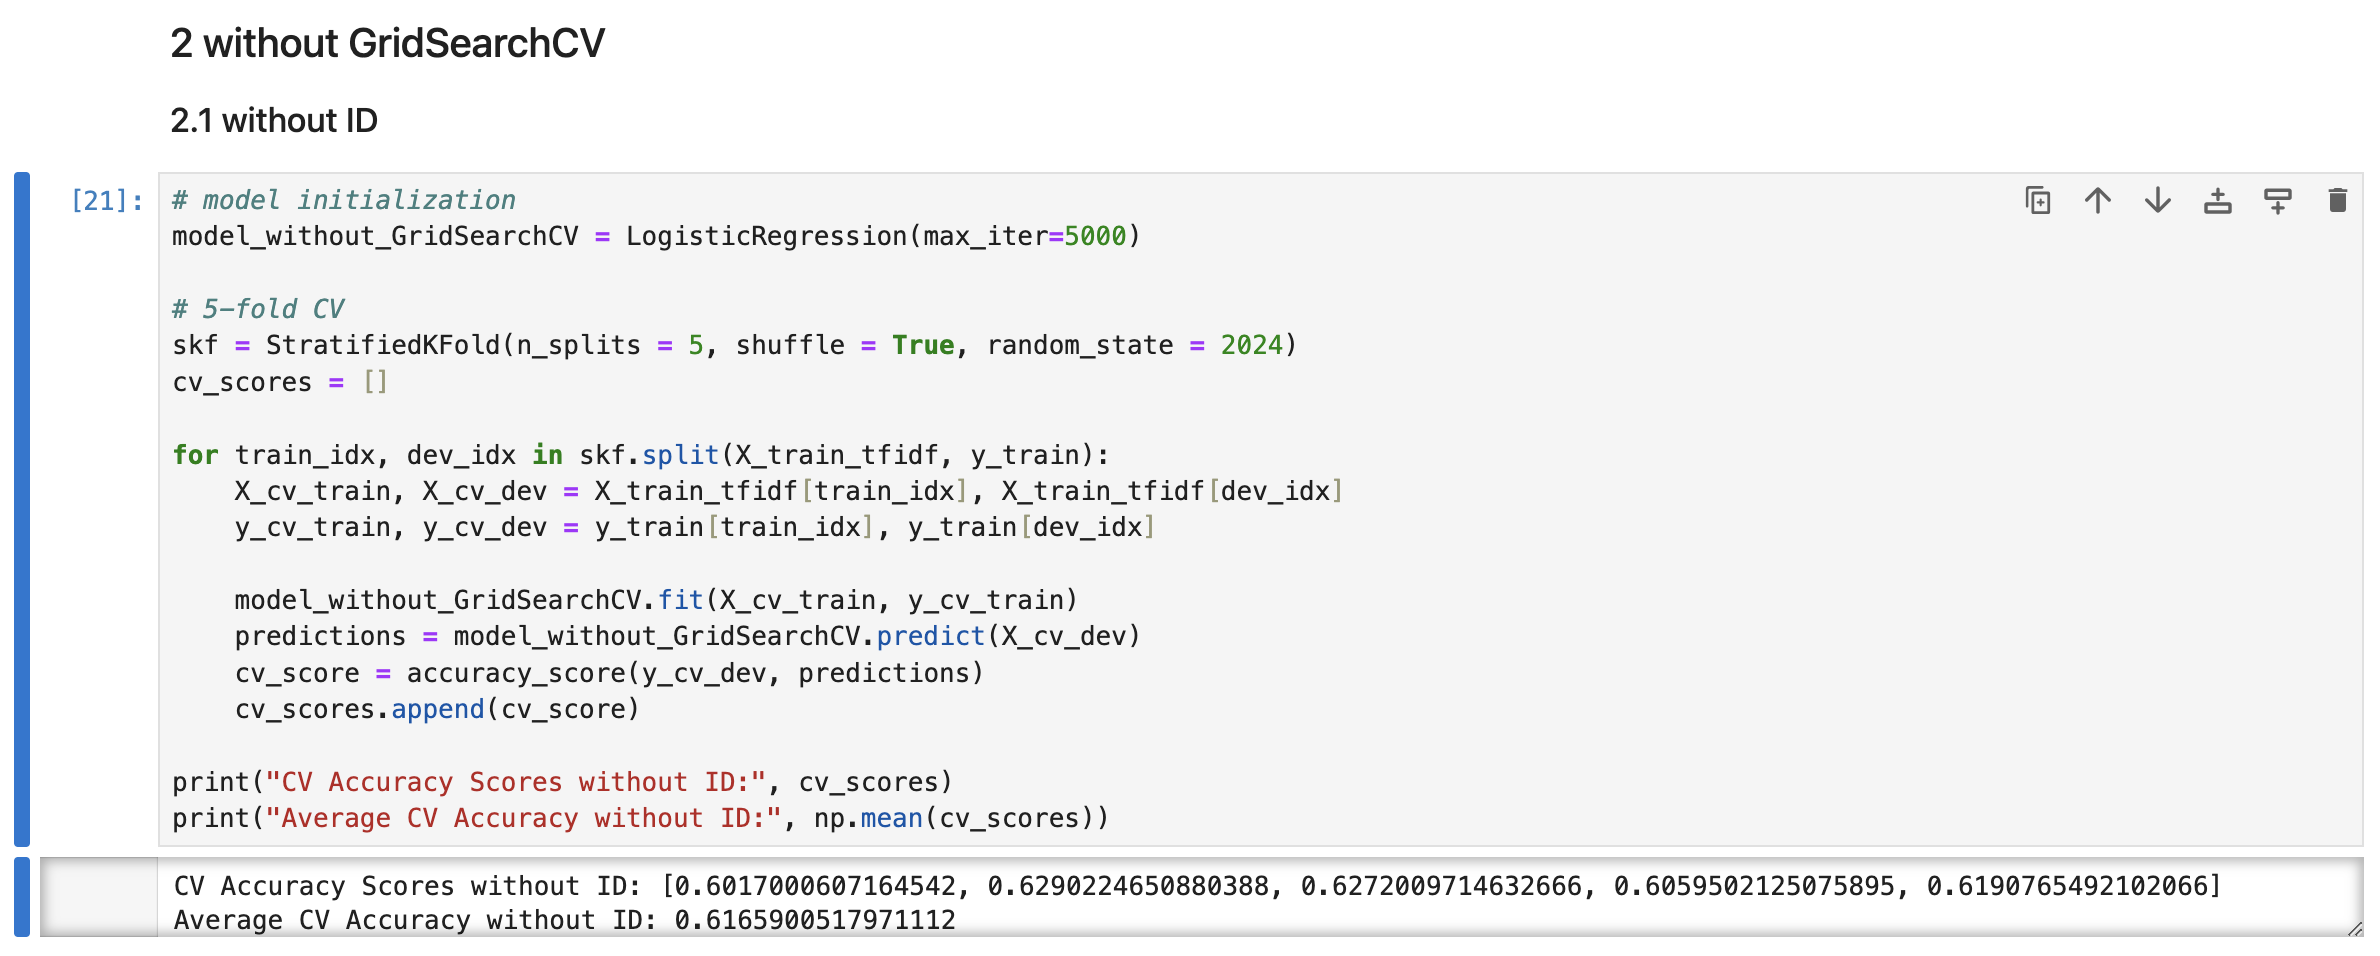

#### 2.2 With ID

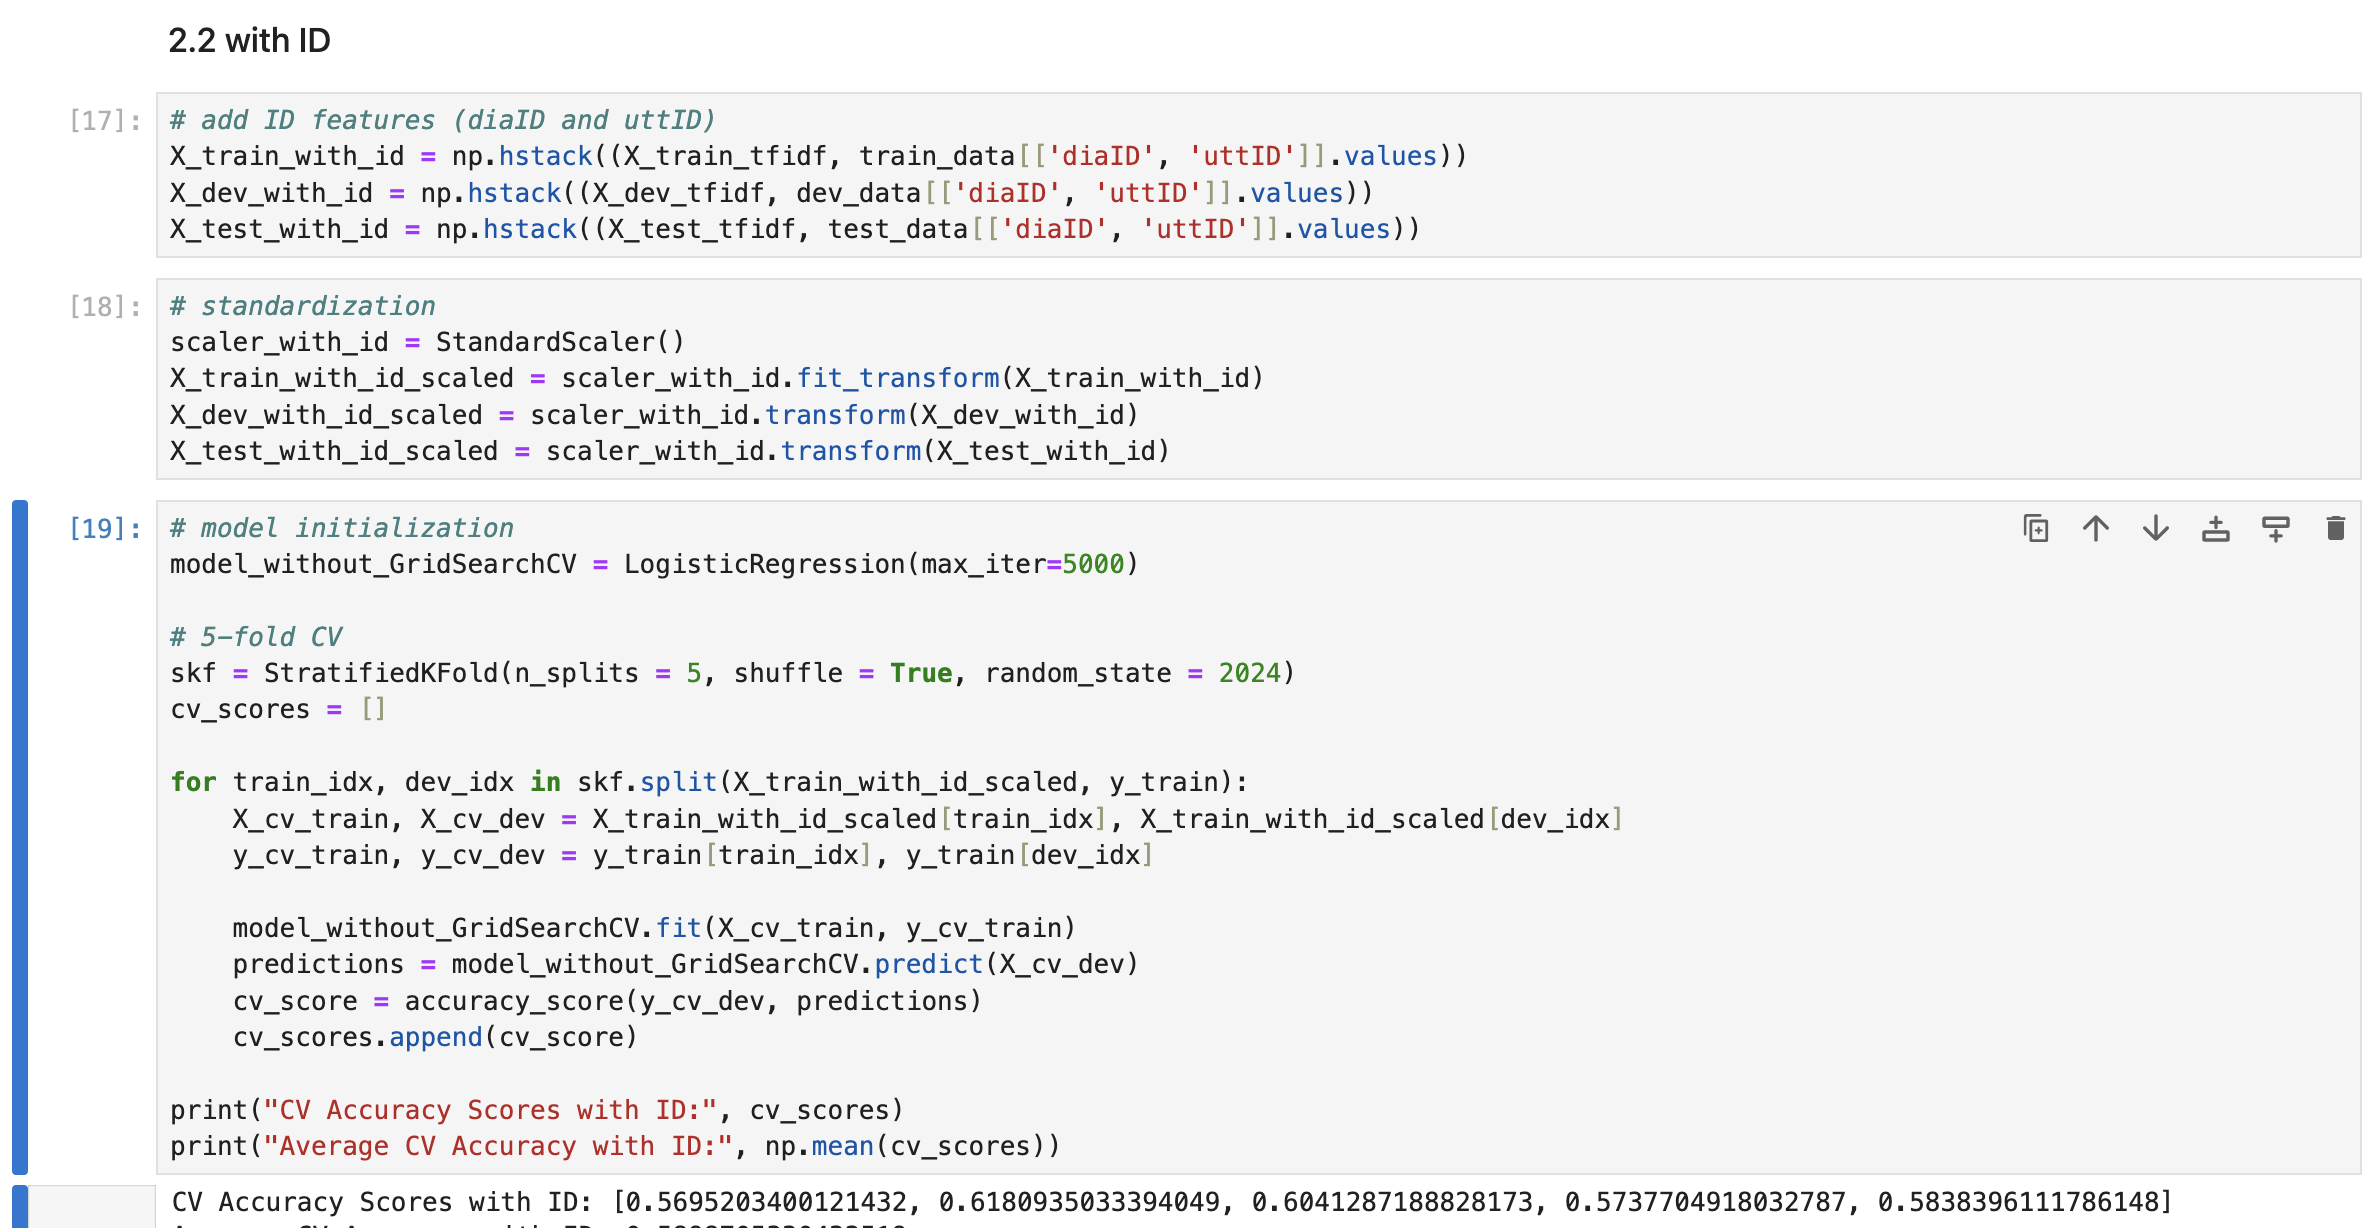